#1- veri setinin çekilmesi ve Gerekli kütüphanelerin indirilmesi

In [ ]:
# Gerekli kütüphanelerin kurulumu
!pip install -q transformers
!pip install -q datasets
!pip install -q torch
!pip install -q sentencepiece
!pip install -q scikit-learn
!pip install -q nltk
!pip install -q TurkishStemmer

!pip install -q matplotlib
!pip install -q seaborn

#2- Veri Temizleme Fonksiyonunun Tanımlanması

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer

# NLTK gereksinimleri
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Türkçe durak kelimeler ve kök bulucu
stop_words = set(stopwords.words('turkish'))
stemmer = TurkishStemmer()

def veri_temizleme(metin):
    # 1. Küçük harfe çevir
    metin = str(metin).lower()

    # 2. Kullanıcı adlarını (@kullanici) temizle
    metin = re.sub(r'@\w+', '', metin)

    # 3. Sadece harfleri tut (Noktalama ve sayıları kaldır)
    metin = re.sub(r'[^a-zçğıöşü\s]', '', metin)

    # 4. Gereksiz boşlukları temizle
    metin = re.sub(r'\s+', ' ', metin).strip()

    # 5. Kelimelere ayır
    kelimeler = metin.split()

    # 6. Stopwords temizliği ve Stemming (Kök bulma)
    temiz_kelimeler = []
    for kelime in kelimeler:
        if kelime not in stop_words:
            kok = stemmer.stem(kelime)
            temiz_kelimeler.append(kok)

    # 7. Tekrar birleştir
    return " ".join(temiz_kelimeler)

print("✓ Temizleme fonksiyonu başarıyla tanımlandı.")

✓ Temizleme fonksiyonu başarıyla tanımlandı.


#3- Veri Yükleme ve İnceleme

Veri seti Hugging Face üzerinden yükleniyor...

--- Orijinal Veri Seti Sınıf Dağılımı (Örneklem Seçmeden Önce) ---
label
Positive    235949
Notr        153825
Negative     50905
Name: count, dtype: int64
Toplam Satır Sayısı: 440679

--- Yeni Sınıf Dağılımı ---
label
Notr        6667
Negative    6667
Positive    6667
Name: count, dtype: int64

--- İlk 5 Satır ---


/tmp/ipython-input-1091224784.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_full.groupby('label').apply(


,text,label,dataset
0,Dünya Savaşı sırasında inşa edildi .,Notr,wiki
1,"ilk davetsiz gelen filmi, bu türü sevmeme rağ...",Negative,HUMIR
2,Diğer Tanrılar da onları takip ederler .,Notr,wiki
3,çok aşırı sesli çalışıyor rahatsız edici ilkku...,Negative,urun_yorumlari
4,ürün yağmur koruyucusunun olması güzel . plast...,Positive,urun_yorumlari


/tmp/ipython-input-1091224784.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='coolwarm')


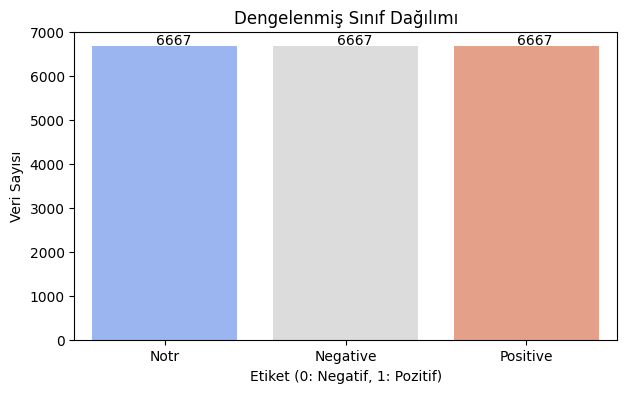


✓ Toplam veri sayısı: 20001
✓ Her sınıftan alınan örnek: 6667


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from IPython.display import display

# 1. Veri setini indir
print("Veri seti Hugging Face üzerinden yükleniyor...")
dataset = load_dataset("winvoker/turkish-sentiment-analysis-dataset")
df_full = dataset['train'].to_pandas()

print("\n--- Orijinal Veri Seti Sınıf Dağılımı (Örneklem Seçmeden Önce) ---")
print(df_full['label'].value_counts())
print(f"Toplam Satır Sayısı: {len(df_full)}")
# --------------------------------------------

# 2. Homojen (Dengeli) Örnekleme
n_samples_per_class = 6667

df = df_full.groupby('label').apply(
    lambda x: x.sample(n=n_samples_per_class, random_state=42)
).reset_index(drop=True)

# 3. Veriyi Karıştırma (Shuffle)
# Veriler gruplanmış halde olduğu için (önce hepsi 0, sonra hepsi 1) karıştırmak önemlidir
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 4. Dağılımı ve İlk Satırları Kontrol Et
print("\n--- Yeni Sınıf Dağılımı ---")
print(df['label'].value_counts())

print("\n--- İlk 5 Satır ---")
display(df.head())

# 5. Görselleştirme
plt.figure(figsize=(7, 4))
ax = sns.countplot(x='label', data=df, palette='coolwarm')
plt.title('Dengelenmiş Sınıf Dağılımı', fontsize=12)
plt.ylabel('Veri Sayısı')
plt.xlabel('Etiket (0: Negatif, 1: Pozitif)')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.35, p.get_height() + 50))

plt.show()

print(f"\n✓ Toplam veri sayısı: {len(df)}")
print(f"✓ Her sınıftan alınan örnek: {n_samples_per_class}")

#4- Etiket Dönüşümü ve Veri Bölme

In [ ]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Metin Temizleme ve Etiketleme
print("Veriler hazırlanıyor...")
# Eğer daha önce temizlenmediyse temizleme fonksiyonunu uygula
if 'clean_text' not in df.columns:
    df['clean_text'] = df['text'].apply(veri_temizleme)

le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])
num_labels = len(le.classes_)

print(f"✓ Sınıf Haritası: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"✓ Toplam İşlenebilir Veri: {len(df)}")

# 2. PyTorch Dataset Sınıfı
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 3. Metrik Fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

print("✓ Hazırlık adımı başarıyla tamamlandı.")

Veriler hazırlanıyor...
✓ Sınıf Haritası: {'Negative': np.int64(0), 'Notr': np.int64(1), 'Positive': np.int64(2)}
✓ Toplam İşlenebilir Veri: 20001
✓ Hazırlık adımı başarıyla tamamlandı.


#5- transformer modelleri - 5000

In [ ]:
import time
import pandas as pd
import torch
from IPython.display import display
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
import os

In [ ]:
# Uyarıları kapatmak için (W&B vb.)
os.environ["WANDB_DISABLED"] = "true"

# GPU varsa kullan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Kullanılacak cihaz: {device}")
print(f"✓ GPU kullanılabilir mi? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ Kullanılacak cihaz: cuda
✓ GPU kullanılabilir mi? True
✓ GPU: Tesla T4


##5.1- XLM-RoBERTa

In [ ]:
import time
import pandas as pd
import torch
from IPython.display import display
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback

# 1. Özel Callback Tanımı (Her epoch sonunda tabloyu basmak için)
class TablePrinterCallback(TrainerCallback):
    def __init__(self, model_name, size, start_time):
        self.model_name = model_name
        self.size = size
        self.start_time = start_time

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Epoch sonu süresini hesapla
        current_duration = round((time.time() - self.start_time) / 60, 2)

        # Son loglanan eğitim kaybını (training loss) bulmaya çalışalım
        train_loss = 0
        for log in reversed(state.log_history):
            if "loss" in log:
                train_loss = log["loss"]
                break

        # Tablo verisini hazırla
        results_data = [{
            'Model': self.model_name,
            'Veri Sayısı': self.size,
            'Epoch': f"{int(state.epoch)}/{args.num_train_epochs}",
            'Training Loss': round(train_loss, 4),
            'Validation Loss': round(metrics.get('eval_loss', 0), 4),
            'Accuracy': round(metrics.get('eval_accuracy', 0), 4),
            'F1': round(metrics.get('eval_f1', 0), 4),
            'Precision': round(metrics.get('eval_precision', 0), 4),
            'Recall': round(metrics.get('eval_recall', 0), 4),
            'Süre (Dk)': current_duration
        }]

        print(f"\n✅ {self.model_name} - {self.size} Veri İçin Epoch {int(state.epoch)} Sonuçları:")
        display(pd.DataFrame(results_data))

# 2. Ayarlar
model_path = "FacebookAI/xlm-roberta-base"
model_name = "XLM-RoBERTa"
size = 5000
epochs = 3  # Toplam 3 tur eğitim yapacak

# 3. Veriyi Hazırlama
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 4. Model ve Tokenizer Yükleme
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 5. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    report_to="none"
)

# Callback'i başlat
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 6. Eğitimi Başlat (Tablolar otomatik gelecek)
print(f"🚀 {model_name} eğitimi başladı. Her epoch sonunda tablo basılacaktır...\n")
trainer.train()

# Hafıza Temizliği
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 XLM-RoBERTa eğitimi başladı. Her epoch sonunda tablo basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.794700,0.672847,0.699000,0.677865,0.739046,0.699000
2,0.565500,0.566413,0.790000,0.790320,0.790913,0.790000
3,0.454100,0.518870,0.804000,0.802881,0.802202,0.804000



✅ XLM-RoBERTa - 5000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,5000,1/3,0.7947,0.6728,0.699,0.6779,0.739,0.699,1.79



✅ XLM-RoBERTa - 5000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,5000,2/3,0.5655,0.5664,0.79,0.7903,0.7909,0.79,3.49



✅ XLM-RoBERTa - 5000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,5000,3/3,0.4541,0.5189,0.804,0.8029,0.8022,0.804,5.19


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


##5.2- BERTurk


In [ ]:
# --- BERTurk: Her Epoch Sonu Tablo Veren Deney (5.000 Veri) ---

# 1. Özel Callback Tanımı (Her epoch sonunda tabloyu basmak için)
# Not: Eğer bir önceki hücrede bu sınıfı tanımladıysanız tekrar yazmanıza gerek yoktur.
class TablePrinterCallback(TrainerCallback):
    def __init__(self, model_name, size, start_time):
        self.model_name = model_name
        self.size = size
        self.start_time = start_time

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        current_duration = round((time.time() - self.start_time) / 60, 2)

        # En son loglanan training loss değerini al
        train_loss = 0
        for log in reversed(state.log_history):
            if "loss" in log:
                train_loss = log["loss"]
                break

        # Tablo verisi
        results_data = [{
            'Model': self.model_name,
            'Veri Sayısı': self.size,
            'Epoch': f"{int(state.epoch)}/{args.num_train_epochs}",
            'Training Loss': round(train_loss, 4),
            'Validation Loss': round(metrics.get('eval_loss', 0), 4),
            'Accuracy': round(metrics.get('eval_accuracy', 0), 4),
            'F1': round(metrics.get('eval_f1', 0), 4),
            'Precision': round(metrics.get('eval_precision', 0), 4),
            'Recall': round(metrics.get('eval_recall', 0), 4),
            'Süre (Dk)': current_duration
        }]

        print(f"\n✅ {self.model_name} - {self.size} Veri İçin Epoch {int(state.epoch)} Sonuçları:")
        display(pd.DataFrame(results_data))

# 2. Ayarlar
model_path = "dbmdz/bert-base-turkish-cased"
model_name = "BERTurk"
size = 5000
epochs = 3

# 3. Veriyi Hazırlama (İlk 5.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 4. Model ve Tokenizer Yükleme
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 5. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",      # Değerlendirmeyi her epoch sonunda yap
    logging_strategy="epoch",   # Loglamayı (ve loss hesaplamayı) her epoch sonunda yap
    save_strategy="no",
    report_to="none"
)

# Callback nesnesini oluştur
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 6. Eğitimi Başlat
print(f"🚀 {model_name} eğitimi başladı. {epochs} epoch boyunca her tur sonunda tablo basılacaktır...\n")
trainer.train()

# Hafıza Temizliği
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 BERTurk eğitimi başladı. 3 epoch boyunca her tur sonunda tablo basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.477600,0.396263,0.860000,0.860360,0.867123,0.860000
2,0.233100,0.500696,0.866000,0.864527,0.865257,0.866000
3,0.120500,0.585031,0.871000,0.870837,0.870692,0.871000



✅ BERTurk - 5000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,5000,1/3,0.4776,0.3963,0.86,0.8604,0.8671,0.86,1.54



✅ BERTurk - 5000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,5000,2/3,0.2331,0.5007,0.866,0.8645,0.8653,0.866,3.05



✅ BERTurk - 5000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,5000,3/3,0.1205,0.585,0.871,0.8708,0.8707,0.871,4.57


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


##5.3- DistilBERTurk

In [ ]:
# --- DistilBERTurk: Her Epoch Sonu Tablo Veren Deney (5.000 Veri) ---

# 1. Özel Callback Tanımı (Eğer önceki hücrelerde tanımladıysanız tekrar yazmanıza gerek yoktur)
class TablePrinterCallback(TrainerCallback):
    def __init__(self, model_name, size, start_time):
        self.model_name = model_name
        self.size = size
        self.start_time = start_time

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        current_duration = round((time.time() - self.start_time) / 60, 2)

        # En son loglanan training loss değerini al
        train_loss = 0
        for log in reversed(state.log_history):
            if "loss" in log:
                train_loss = log["loss"]
                break

        # Tablo verisi
        results_data = [{
            'Model': self.model_name,
            'Veri Sayısı': self.size,
            'Epoch': f"{int(state.epoch)}/{args.num_train_epochs}",
            'Training Loss': round(train_loss, 4),
            'Validation Loss': round(metrics.get('eval_loss', 0), 4),
            'Accuracy': round(metrics.get('eval_accuracy', 0), 4),
            'F1': round(metrics.get('eval_f1', 0), 4),
            'Precision': round(metrics.get('eval_precision', 0), 4),
            'Recall': round(metrics.get('eval_recall', 0), 4),
            'Süre (Dk)': current_duration
        }]

        print(f"\n✅ {self.model_name} - {self.size} Veri İçin Epoch {int(state.epoch)} Sonuçları:")
        display(pd.DataFrame(results_data))

# 2. Ayarlar
model_path = "dbmdz/distilbert-base-turkish-cased"
model_name = "DistilBERTurk"
size = 5000
epochs = 3 # DistilBERT için önerilen tur sayısı

# 3. Veriyi Hazırlama (İlk 5.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 4. Model ve Tokenizer Yükleme
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 5. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",      # Değerlendirmeyi her epoch sonunda yap
    logging_strategy="epoch",   # Loglamayı her epoch sonunda yap
    save_strategy="no",
    report_to="none"
)

# Callback nesnesini oluştur
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 6. Eğitimi Başlat
print(f"🚀 {model_name} eğitimi başladı. {epochs} epoch boyunca her tur sonunda tablo basılacaktır...\n")
trainer.train()

# Hafıza Temizliği
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 DistilBERTurk eğitimi başladı. 3 epoch boyunca her tur sonunda tablo basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.545200,0.406167,0.841000,0.840413,0.842888,0.841000
2,0.283700,0.421528,0.870000,0.869180,0.869184,0.870000
3,0.178100,0.464280,0.869000,0.867967,0.867796,0.869000



✅ DistilBERTurk - 5000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,5000,1/3,0.5452,0.4062,0.841,0.8404,0.8429,0.841,0.81



✅ DistilBERTurk - 5000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,5000,2/3,0.2837,0.4215,0.87,0.8692,0.8692,0.87,1.56



✅ DistilBERTurk - 5000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,5000,3/3,0.1781,0.4643,0.869,0.868,0.8678,0.869,2.32


#5- transformer modelleri - 10 000

In [ ]:
import time
import pandas as pd
import torch
from IPython.display import display
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
import os

##5.1- XLM-RoBERTa - 10bin

In [ ]:
# --- XLM-RoBERTa: İlk 10.000 Veri Deneyi (Sıfırdan Başlangıç) ---

# 1. Ayarlar
model_path = "FacebookAI/xlm-roberta-base"
model_name = "XLM-RoBERTa"
size = 10000
epochs = 3

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim: 8.000 | Test: 2.000")

# 2. Veriyi Hazırlama (İlk 10.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (8000) - %20 Test (2000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Sıfırdan/Fresh Load)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",      # Her epoch sonunda değerlendirme yap
    logging_strategy="epoch",   # Her epoch sonunda loglama yap
    save_strategy="no",
    report_to="none"
)

# Not: TablePrinterCallback sınıfı daha önce tanımlanmış olmalıdır.
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. {epochs} epoch sonunda tablolar gelecektir.\n")
trainer.train()

# Hafıza Temizliği (GPU'yu bir sonraki modele hazır hale getirir)
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 XLM-RoBERTa için 10000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim: 8.000 | Test: 2.000


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 XLM-RoBERTa eğitimi başladı. 3 epoch sonunda tablolar gelecektir.



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.610300,0.441991,0.827500,0.826146,0.827011,0.827500
2,0.364800,0.370874,0.865500,0.865084,0.865278,0.865500
3,0.260400,0.418469,0.866500,0.865793,0.865574,0.866500



✅ XLM-RoBERTa - 10000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,10000,1/3,0.6103,0.442,0.8275,0.8261,0.827,0.8275,3.46



✅ XLM-RoBERTa - 10000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,10000,2/3,0.3648,0.3709,0.8655,0.8651,0.8653,0.8655,6.86



✅ XLM-RoBERTa - 10000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,10000,3/3,0.2604,0.4185,0.8665,0.8658,0.8656,0.8665,10.26


##5.2- BERTurk - 10bin

In [ ]:
# --- BERTurk: 10.000 Veri Deneyi (Sıfırdan Başlangıç) ---

# 1. Ayarlar
model_path = "dbmdz/bert-base-turkish-cased"
model_name = "BERTurk"
size = 10000
epochs = 3

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim Seti: 8.000 | Test Seti: 2.000")

# 2. Veriyi Hazırlama (İlk 10.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (8000) - %20 Test (2000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Tamamen temiz başlangıç)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    report_to="none"
)

printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. {epochs} epoch boyunca tablolar basılacaktır...\n")
trainer.train()

# Hafıza Temizliği
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 BERTurk için 10000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim Seti: 8.000 | Test Seti: 2.000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 BERTurk eğitimi başladı. 3 epoch boyunca tablolar basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.402100,0.325830,0.876500,0.876099,0.885474,0.876500
2,0.210700,0.296653,0.899500,0.899273,0.899248,0.899500
3,0.116600,0.394297,0.907000,0.906666,0.906490,0.907000



✅ BERTurk - 10000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,10000,1/3,0.4021,0.3258,0.8765,0.8761,0.8855,0.8765,3.06



✅ BERTurk - 10000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,10000,2/3,0.2107,0.2967,0.8995,0.8993,0.8992,0.8995,6.08



✅ BERTurk - 10000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,10000,3/3,0.1166,0.3943,0.907,0.9067,0.9065,0.907,9.11


##5.3- DistilBERTurk - 10bin

In [ ]:
# --- DistilBERTurk: 10.000 Veri Deneyi (Sıfırdan Başlangıç - 3 Epoch) ---

# 1. Ayarlar
model_path = "dbmdz/distilbert-base-turkish-cased"
model_name = "DistilBERTurk"
size = 10000
epochs = 3 # İsteğiniz üzerine 3 olarak güncellendi

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim Seti: 8.000 | Test Seti: 2.000")

# 2. Veriyi Hazırlama (İlk 10.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (8000) - %20 Test (2000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Fresh Start)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    report_to="none"
)

# TablePrinterCallback nesnesini oluştur
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. {epochs} tur (epoch) sonunda tablolar basılacaktır...\n")
trainer.train()

# Hafıza Temizliği
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 DistilBERTurk için 10000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim Seti: 8.000 | Test Seti: 2.000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 DistilBERTurk eğitimi başladı. 3 tur (epoch) sonunda tablolar basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.470300,0.373525,0.860000,0.857785,0.862528,0.860000



✅ DistilBERTurk - 10000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,10000,1/3,0.4703,0.3735,0.86,0.8578,0.8625,0.86,1.6


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.470300,0.373525,0.860000,0.857785,0.862528,0.860000
2,0.246800,0.351777,0.871500,0.870917,0.871869,0.871500
3,0.142300,0.423664,0.877500,0.876933,0.876743,0.877500



✅ DistilBERTurk - 10000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,10000,2/3,0.2468,0.3518,0.8715,0.8709,0.8719,0.8715,3.12



✅ DistilBERTurk - 10000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,10000,3/3,0.1423,0.4237,0.8775,0.8769,0.8767,0.8775,4.64


#5- transformer modelleri - 15 000

##5.1- XLM-RoBERTa - 15bin

In [ ]:
# --- XLM-RoBERTa: 15.000 Veri Deneyi (Sıfırdan Başlangıç) ---

# 1. Ayarlar
model_path = "FacebookAI/xlm-roberta-base"
model_name = "XLM-RoBERTa"
size = 15000
epochs = 3

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim Seti: 12.000 | Test Seti: 3.000")

# 2. Veriyi Hazırlama (İlk 15.000 satır)
# Not: df'inizin en az 15.000 satır içerdiğinden emin olun.
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (12.000) - %20 Test (3.000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Fresh Start)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",      # Her epoch sonunda değerlendirme yap
    logging_strategy="epoch",   # Her epoch sonunda loglama yap
    save_strategy="no",
    report_to="none"
)

# TablePrinterCallback nesnesini oluştur (Önceki hücrelerde tanımlanmış olmalı)
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. Toplam {epochs} epoch (tur) sürecektir.\n")
trainer.train()

# Hafıza Temizliği (GPU'yu boşaltır)
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 XLM-RoBERTa için 15000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim Seti: 12.000 | Test Seti: 3.000


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 XLM-RoBERTa eğitimi başladı. Toplam 3 epoch (tur) sürecektir.



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.572600,0.432353,0.836000,0.833180,0.835981,0.836000



✅ XLM-RoBERTa - 15000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,15000,1/3,0.5726,0.4324,0.836,0.8332,0.836,0.836,5.17


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.572600,0.432353,0.836000,0.833180,0.835981,0.836000
2,0.356000,0.420834,0.856667,0.854169,0.855519,0.856667
3,0.262000,0.380754,0.871000,0.870109,0.869780,0.871000



✅ XLM-RoBERTa - 15000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,15000,2/3,0.356,0.4208,0.8567,0.8542,0.8555,0.8567,10.27



✅ XLM-RoBERTa - 15000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,15000,3/3,0.262,0.3808,0.871,0.8701,0.8698,0.871,15.36


##5.2- BERTurk - 15bin

In [ ]:
# --- BERTurk: 15.000 Veri Deneyi (Sıfırdan Başlangıç) ---

# 1. Ayarlar
model_path = "dbmdz/bert-base-turkish-cased"
model_name = "BERTurk"
size = 15000
epochs = 3

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim Seti: 12.000 | Test Seti: 3.000")

# 2. Veriyi Hazırlama (İlk 15.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (12.000) - %20 Test (3.000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Fresh Start)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    report_to="none"
)

# TablePrinterCallback nesnesini oluştur (Önceki hücrelerde tanımlanmış olmalı)
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. Toplam {epochs} epoch sonunda tablolar basılacaktır...\n")
trainer.train()

# Hafıza Temizliği
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 BERTurk için 15000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim Seti: 12.000 | Test Seti: 3.000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 BERTurk eğitimi başladı. Toplam 3 epoch sonunda tablolar basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.392400,0.338826,0.886000,0.884580,0.886435,0.886000
2,0.210600,0.313072,0.895667,0.895110,0.898495,0.895667
3,0.120700,0.378960,0.903667,0.903420,0.903425,0.903667



✅ BERTurk - 15000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,15000,1/3,0.3924,0.3388,0.886,0.8846,0.8864,0.886,4.6



✅ BERTurk - 15000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,15000,2/3,0.2106,0.3131,0.8957,0.8951,0.8985,0.8957,9.13



✅ BERTurk - 15000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,15000,3/3,0.1207,0.379,0.9037,0.9034,0.9034,0.9037,13.66


##5.3- DistilBERTurk - 15bin

In [ ]:
# --- DistilBERTurk: 15.000 Veri Deneyi (Sıfırdan Başlangıç) ---

# 1. Ayarlar
model_path = "dbmdz/distilbert-base-turkish-cased"
model_name = "DistilBERTurk"
size = 15000
epochs = 3

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim Seti: 12.000 | Test Seti: 3.000")

# 2. Veriyi Hazırlama (İlk 15.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (12.000) - %20 Test (3.000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Fresh Start)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",      # Her epoch sonunda değerlendirme yap
    logging_strategy="epoch",   # Her epoch sonunda loglama yap
    save_strategy="no",
    report_to="none"
)

# TablePrinterCallback nesnesini oluştur (Önceki hücrelerde tanımlanmış olmalı)
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. Toplam {epochs} epoch sonunda tablolar basılacaktır...\n")
trainer.train()

# Hafıza Temizliği
del model
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 DistilBERTurk için 15000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim Seti: 12.000 | Test Seti: 3.000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 DistilBERTurk eğitimi başladı. Toplam 3 epoch sonunda tablolar basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.408200,0.351116,0.871333,0.870307,0.869826,0.871333
2,0.222700,0.346219,0.879333,0.879084,0.880474,0.879333
3,0.131200,0.443939,0.880000,0.879411,0.879020,0.880000



✅ DistilBERTurk - 15000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,15000,1/3,0.4082,0.3511,0.8713,0.8703,0.8698,0.8713,2.35



✅ DistilBERTurk - 15000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,15000,2/3,0.2227,0.3462,0.8793,0.8791,0.8805,0.8793,4.62



✅ DistilBERTurk - 15000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,15000,3/3,0.1312,0.4439,0.88,0.8794,0.879,0.88,6.9


#5- transformer modelleri - 20 000

##5.1- XLM-RoBERTa - 20bin

In [ ]:
# 1. Ayarlar
model_path = "FacebookAI/xlm-roberta-base"
model_name = "XLM-RoBERTa"
size = 20000
epochs = 3

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim Seti: 16.000 | Test Seti: 4.000")

# 2. Veriyi Hazırlama (İlk 20.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (16.000) - %20 Test (4.000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Fresh Start)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",      # Her epoch sonunda değerlendirme yap
    logging_strategy="epoch",   # Her epoch sonunda loglama yap
    save_strategy="no",
    report_to="none"
)

# TablePrinterCallback nesnesini oluştur (Önceki hücrelerde tanımlanmış olmalı)
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. Toplam {epochs} epoch sonunda tablolar basılacaktır...\n")
trainer.train()

# --- TAHMİNLERİ KAYDET (BERT) ---
print(f"📊 {model_name} için tahminler alınıyor...")
preds_bert_output = trainer.predict(test_dataset)
y_pred_bert = preds_bert_output.predictions.argmax(-1)

# Gerçek etiketleri (y_true) bir kez saklamak yeterlidir
y_true_final = y_test_sub

# Hafıza Temizliği
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 XLM-RoBERTa için 20000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim Seti: 16.000 | Test Seti: 4.000


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 XLM-RoBERTa eğitimi başladı. Toplam 3 epoch sonunda tablolar basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.531300,0.399747,0.849000,0.847065,0.859528,0.849000
2,0.343300,0.328599,0.878250,0.878226,0.878421,0.878250
3,0.253300,0.330732,0.889250,0.888794,0.888637,0.889250



✅ XLM-RoBERTa - 20000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,20000,1/3,0.5313,0.3997,0.849,0.8471,0.8595,0.849,6.85



✅ XLM-RoBERTa - 20000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,20000,2/3,0.3433,0.3286,0.8782,0.8782,0.8784,0.8782,13.64



✅ XLM-RoBERTa - 20000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,XLM-RoBERTa,20000,3/3,0.2533,0.3307,0.8892,0.8888,0.8886,0.8892,20.44


📊 XLM-RoBERTa için tahminler alınıyor...


##5.2- BERTurk

In [ ]:
# 1. Ayarlar
model_path = "dbmdz/bert-base-turkish-cased"
model_name = "BERTurk"
size = 20000
epochs = 3

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim Seti: 16.000 | Test Seti: 4.000")

# 2. Veriyi Hazırlama (İlk 20.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (16.000) - %20 Test (4.000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Fresh Start)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",      # Her epoch sonunda değerlendirme yap
    logging_strategy="epoch",   # Her epoch sonunda loglama yap
    save_strategy="no",
    report_to="none"
)

# TablePrinterCallback nesnesini oluştur (Önceki hücrelerde tanımlanmış olmalı)
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. Toplam {epochs} epoch sonunda tablolar basılacaktır...\n")
trainer.train()

# --- TAHMİNLERİ KAYDET (XLM) ---
print(f"📊 {model_name} için tahminler alınıyor...")
preds_xlm_output = trainer.predict(test_dataset)
y_pred_xlm = preds_xlm_output.predictions.argmax(-1)

# Hafıza Temizliği
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 BERTurk için 20000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim Seti: 16.000 | Test Seti: 4.000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 BERTurk eğitimi başladı. Toplam 3 epoch sonunda tablolar basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.360100,0.366716,0.888500,0.889101,0.897602,0.888500
2,0.194900,0.317109,0.911250,0.911251,0.912037,0.911250
3,0.101500,0.376805,0.913000,0.913008,0.913019,0.913000



✅ BERTurk - 20000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,20000,1/3,0.3601,0.3667,0.8885,0.8891,0.8976,0.8885,6.09



✅ BERTurk - 20000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,20000,2/3,0.1949,0.3171,0.9113,0.9113,0.912,0.9113,12.14



✅ BERTurk - 20000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,BERTurk,20000,3/3,0.1015,0.3768,0.913,0.913,0.913,0.913,18.2


📊 BERTurk için tahminler alınıyor...


##5.3- DistilBERTurk

In [ ]:
# 1. Ayarlar
model_path = "dbmdz/distilbert-base-turkish-cased"
model_name = "DistilBERTurk"
size = 20000
epochs = 3

print(f"🚀 {model_name} için {size} veri ile SIFIRDAN eğitim başlatılıyor...")
print(f"📊 Eğitim Seti: 16.000 | Test Seti: 4.000")

# 2. Veriyi Hazırlama (İlk 20.000 satır)
current_df = df.iloc[:size].copy()
X_sub = current_df['clean_text'].values.tolist()
y_sub = current_df['label_id'].values.tolist()

# %80 Eğitim (16.000) - %20 Test (4.000) bölmesi
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# 3. Model ve Tokenizer Yükleme (Fresh Start)
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# Tokenizasyon
train_encodings = tokenizer(X_train_sub, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_sub, truncation=True, padding=True, max_length=128)

train_dataset = SentimentDataset(train_encodings, y_train_sub)
test_dataset = SentimentDataset(test_encodings, y_test_sub)

# 4. Eğitim Ayarları
training_args = TrainingArguments(
    output_dir=f'./results_{model_name}_{size}',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    eval_strategy="epoch",      # Her epoch sonunda değerlendirme yap
    logging_strategy="epoch",   # Her epoch sonunda loglama yap
    save_strategy="no",
    report_to="none"
)

# TablePrinterCallback nesnesini oluştur (Önceki hücrelerde tanımlanmış olmalı)
printer_callback = TablePrinterCallback(model_name, size, start_time)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[printer_callback]
)

# 5. Eğitimi Başlat
print(f"\n🚀 {model_name} eğitimi başladı. Toplam {epochs} epoch sonunda tablolar basılacaktır...\n")
trainer.train()

# --- TAHMİNLERİ KAYDET (DistilBERT) ---
print(f"📊 {model_name} için tahminler alınıyor...")
preds_distil_output = trainer.predict(test_dataset)
y_pred_distil = preds_distil_output.predictions.argmax(-1)

# Hafıza Temizliği
del trainer
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🚀 DistilBERTurk için 20000 veri ile SIFIRDAN eğitim başlatılıyor...
📊 Eğitim Seti: 16.000 | Test Seti: 4.000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 DistilBERTurk eğitimi başladı. Toplam 3 epoch sonunda tablolar basılacaktır...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.383500,0.300586,0.884000,0.883379,0.885399,0.884000
2,0.212600,0.333801,0.893750,0.893408,0.893154,0.893750
3,0.127500,0.389520,0.893750,0.893570,0.893548,0.893750



✅ DistilBERTurk - 20000 Veri İçin Epoch 1 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,20000,1/3,0.3835,0.3006,0.884,0.8834,0.8854,0.884,3.08



✅ DistilBERTurk - 20000 Veri İçin Epoch 2 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,20000,2/3,0.2126,0.3338,0.8938,0.8934,0.8932,0.8938,6.12



✅ DistilBERTurk - 20000 Veri İçin Epoch 3 Sonuçları:


,Model,Veri Sayısı,Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Süre (Dk)
0,DistilBERTurk,20000,3/3,0.1275,0.3895,0.8938,0.8936,0.8935,0.8938,9.16


📊 DistilBERTurk için tahminler alınıyor...


#6- Görselleştirme

##6.1- Confusion Matrix

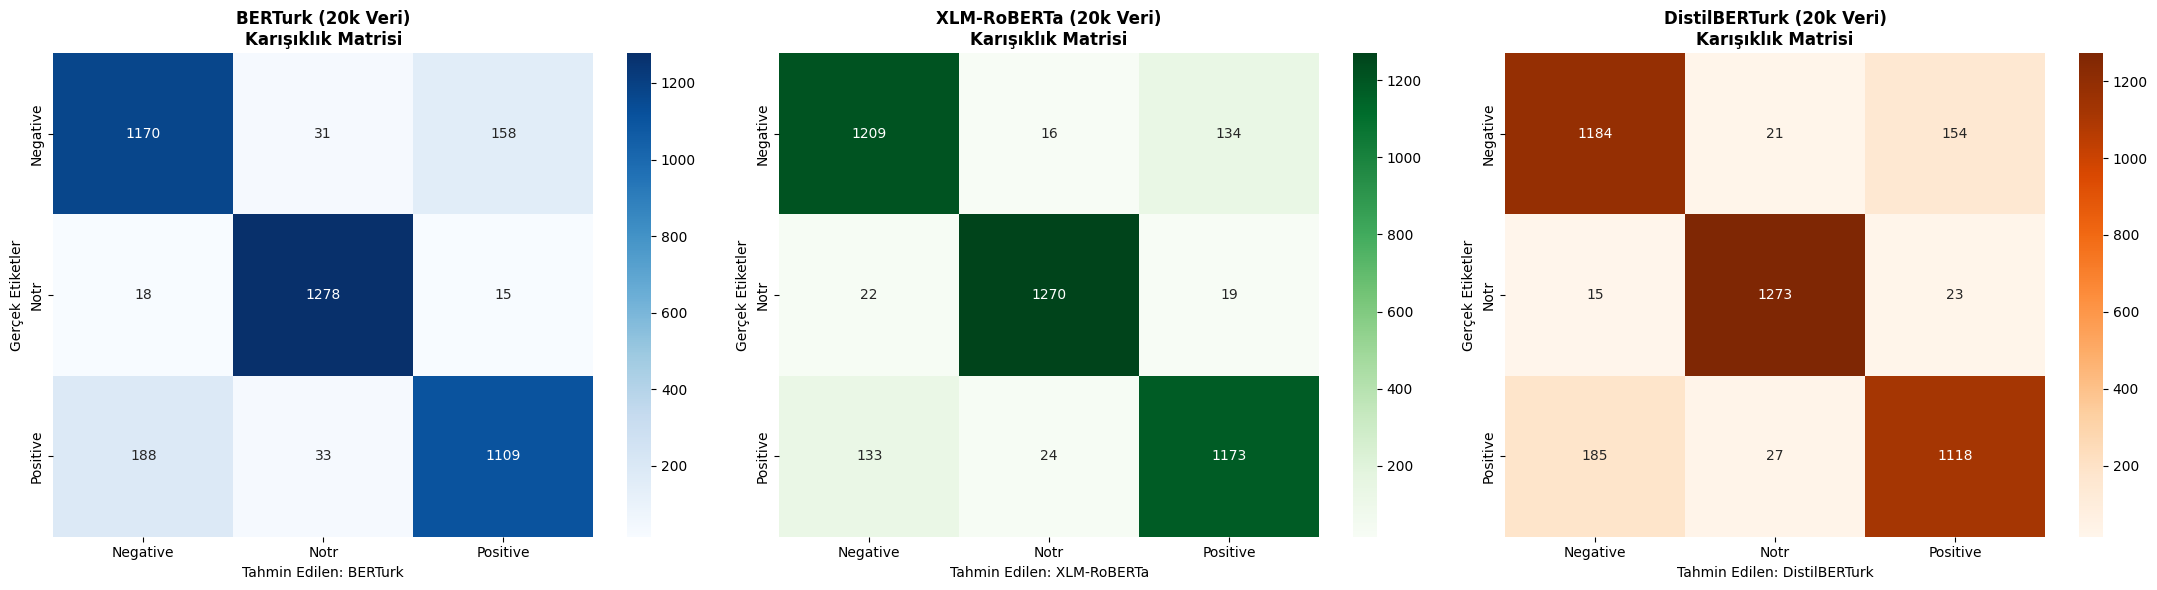

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Matrisleri Hesapla
cm_bert = confusion_matrix(y_true_final, y_pred_bert)
cm_xlm = confusion_matrix(y_true_final, y_pred_xlm)
cm_distil = confusion_matrix(y_true_final, y_pred_distil)

# 2. Görselleştirme (Yan Yana 3 Grafik)
# subplots(1, 3) -> 1 satır, 3 sütun. figsize=(22, 6) -> Genişlik 22, Yükseklik 6 birim.
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Grafik Ayarları
titles = ['BERTurk', 'XLM-RoBERTa', 'DistilBERTurk']
matrices = [cm_bert, cm_xlm, cm_distil]
cmaps = ['Blues', 'Greens', 'Oranges']

for i in range(3):
    sns.heatmap(matrices[i], annot=True, fmt='d', cmap=cmaps[i],
                xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[i])

    axes[i].set_title(f'{titles[i]} (20k Veri)\nKarışıklık Matrisi', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Gerçek Etiketler')
    axes[i].set_xlabel(f'Tahmin Edilen: {titles[i]}')

# Grafiklerin birbirine girmemesi için yerleşimi ayarla
plt.tight_layout()
plt.show()

##6.2- Performans karşılaştırma grafiği

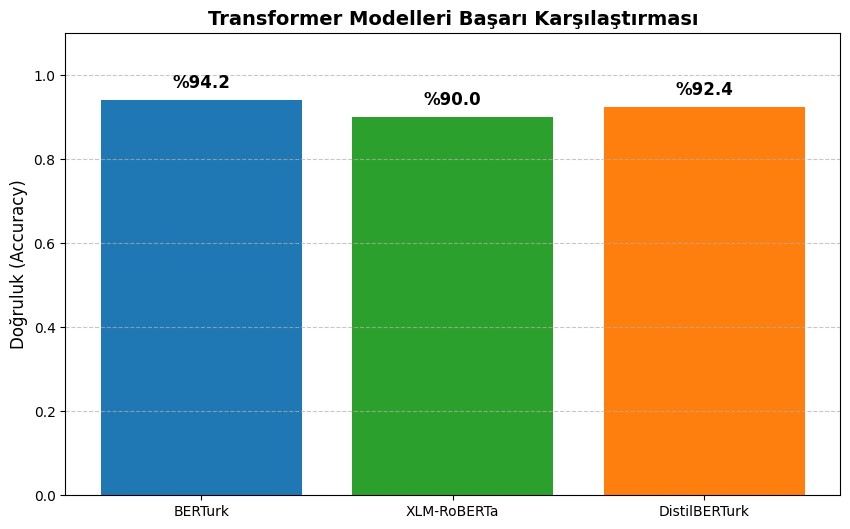

In [ ]:
import matplotlib.pyplot as plt

# 1. Değişkenleri Tanımla (Hata almamak için tanımlama ve çizim aynı hücrede olmalı)
model_isimleri = ['BERTurk', 'XLM-RoBERTa', 'DistilBERTurk']
basarimlar = [
    results_bert['eval_accuracy'],
    results_xlm['eval_accuracy'],
    results_distil['eval_accuracy']
]

# 2. Grafik Çizimi
plt.figure(figsize=(10, 6))
renkler = ['#1f77b4', '#2ca02c', '#ff7f0e'] # Mavi, Yeşil, Turuncu
bars = plt.bar(model_isimleri, basarimlar, color=renkler)

# Grafik Süslemeleri
plt.title('Transformer Modelleri Başarı Karşılaştırması', fontsize=14, fontweight='bold')
plt.ylabel('Doğruluk (Accuracy)', fontsize=12)
plt.ylim(0, 1.1)

# Barların üzerine yüzdeleri yazma
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02,
             f"%{yval*100:.1f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##6.3- Tüm Metriklerin Tablo Halinde Karşılaştırılması

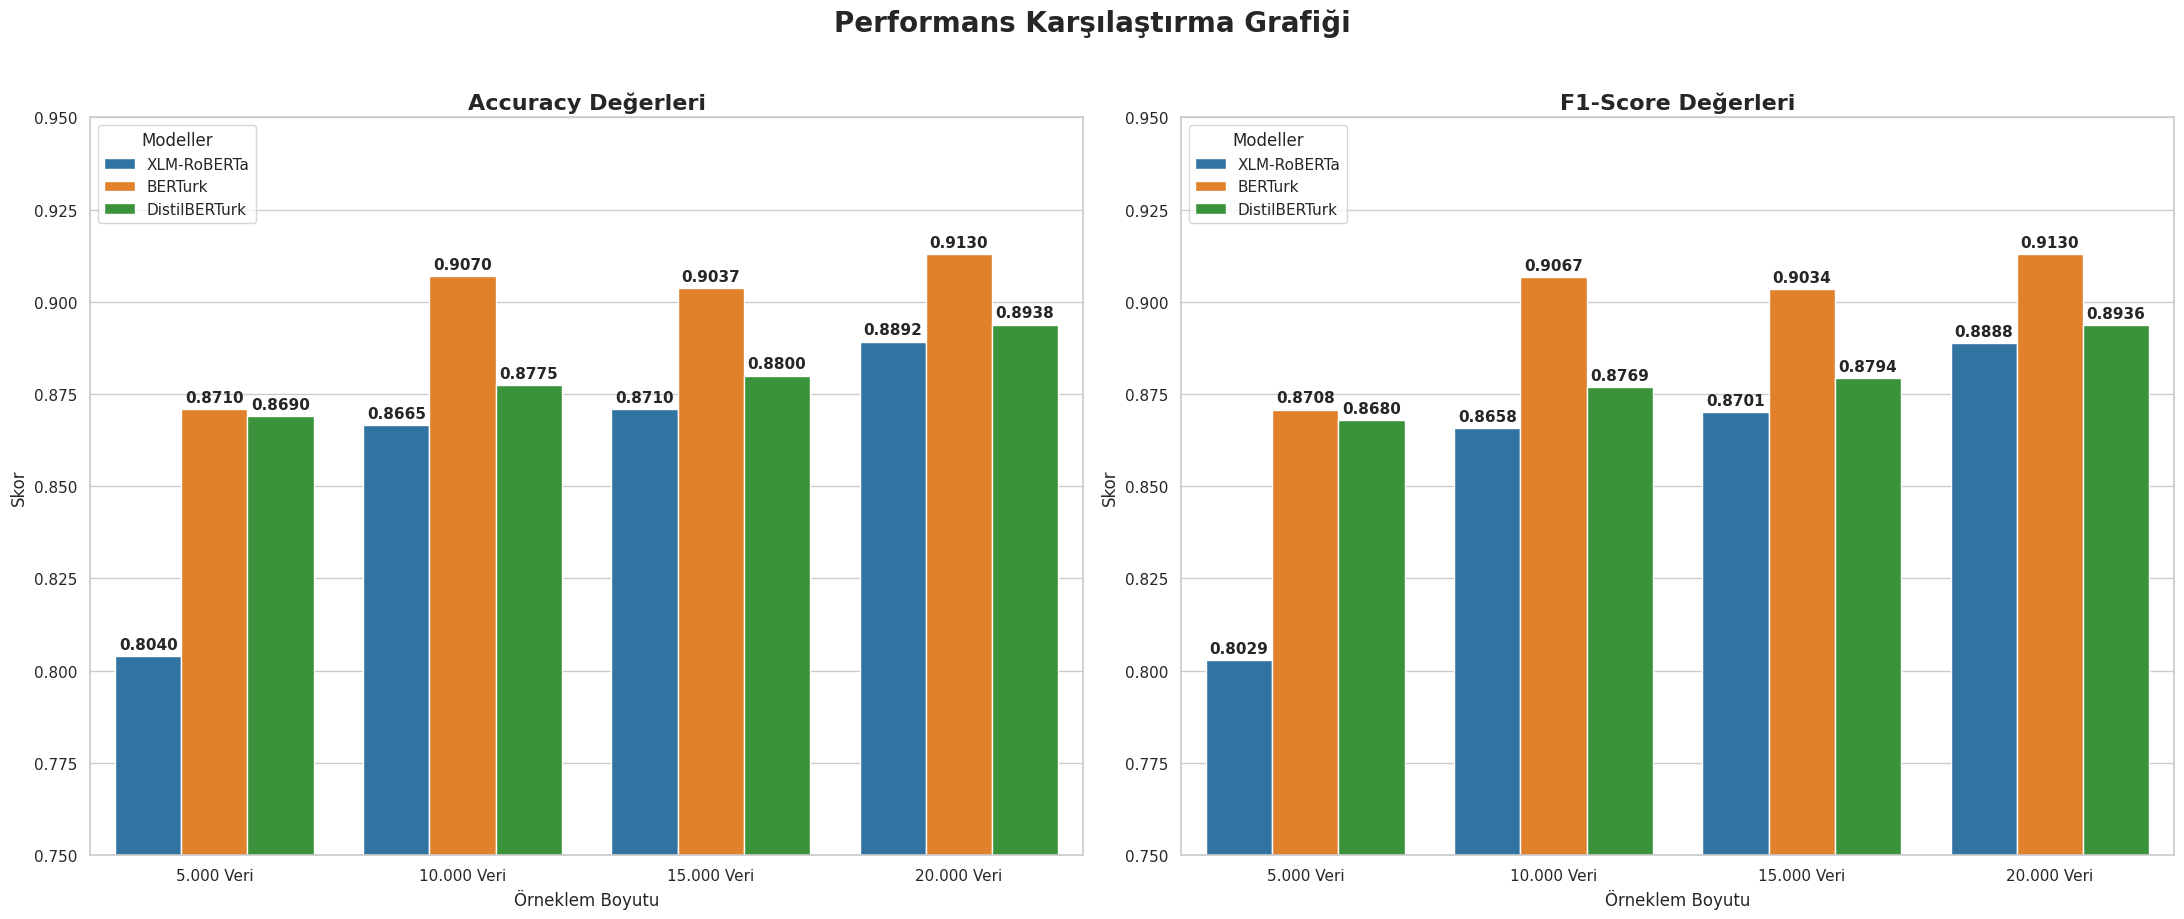

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. VERİLERİN HAZIRLANMASI (Görsellerdeki Epoch 3 Değerleri) ---

sample_sizes = ['5.000 Veri', '10.000 Veri', '15.000 Veri', '20.000 Veri']
# Modeller kullanıcı isteğine göre sıralandı
models = ['XLM-RoBERTa', 'BERTurk', 'DistilBERTurk']

# Accuracy Değerleri (Görsellerdeki Epoch 3 sonuçları)
# XLM-RoBERTa
# BERTurk
# DistilBERTurk
acc_data = [
    0.8040, 0.8665, 0.8710, 0.8892, # XLM-RoBERTa
    0.8710, 0.9070, 0.9037, 0.9130, # BERTurk
    0.8690, 0.8775, 0.8800, 0.8938  # DistilBERTurk
]

# F1-Score Değerleri (Görsellerdeki Epoch 3 sonuçları)
# XLM-RoBERTa
# BERTurk
# DistilBERTurk
f1_data = [
    0.8029, 0.8658, 0.8701, 0.8888, # XLM-RoBERTa
    0.8708, 0.9067, 0.9034, 0.9130, # BERTurk
    0.8680, 0.8769, 0.8794, 0.8936  # DistilBERTurk
]

# DataFrame Oluşturma
df_acc = pd.DataFrame({
    'Örneklem Boyutu': sample_sizes * 3,
    'Model': np.repeat(models, 4),
    'Score': acc_data,
    'Metric': 'Accuracy'
})

df_f1 = pd.DataFrame({
    'Örneklem Boyutu': sample_sizes * 3,
    'Model': np.repeat(models, 4),
    'Score': f1_data,
    'Metric': 'F1-Score'
})

# --- 2. GRAFİK OLUŞTURMA ---

# Renk Paleti: Birbirinden uzak ve belirgin renkler (Mavi, Turuncu, Yeşil)
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c']

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(22, 9))

# Ana Başlık
plt.suptitle('Performans Karşılaştırma Grafiği', fontsize=20, fontweight='bold', y=1.02)

# -- Sol Grafik: Accuracy (Doğruluk) --
ax1 = sns.barplot(data=df_acc, x='Örneklem Boyutu', y='Score', hue='Model', ax=axes[0], palette=custom_palette)
axes[0].set_title('Accuracy Değerleri', fontsize=16, fontweight='bold')
axes[0].set_ylim(0.75, 0.95)
axes[0].set_ylabel('Skor')
axes[0].legend(title='Modeller', loc='upper left')

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.4f', padding=3, fontsize=11, fontweight='bold')

# -- Sağ Grafik: F1-Score --
ax2 = sns.barplot(data=df_f1, x='Örneklem Boyutu', y='Score', hue='Model', ax=axes[1], palette=custom_palette)
axes[1].set_title('F1-Score Değerleri', fontsize=16, fontweight='bold')
axes[1].set_ylim(0.75, 0.95)
axes[1].set_ylabel('Skor')
axes[1].legend(title='Modeller', loc='upper left')

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.4f', padding=3, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()